In [137]:
# -*- coding: utf-8 -*-
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, Flatten
from keras.models import Model, load_model
from keras.callbacks import TensorBoard
from keras.losses import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import pickle
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


## Initialize Variables

In [ ]:
numericColumns = ['MIN_PS', 'MAX_PS', 'AVG_PS', 'STD_DEV_PS', 'FLOW_DURATION', 'MIN_PIAT', 'MAX_PIAT', 'AVG_PIAT', 'STD_DEV_PIAT', 'PKT_TOTAL_COUNT', 'OCTET_TOTAL_COUNT'
             , 'F_MIN_PS', 'F_MAX_PS', 'F_AVG_PS', 'F_STD_DEV_PS', 'F_FLOW_DURATION', 'F_MIN_PIAT', 'F_MAX_PIAT', 'F_AVG_PIAT', 'F_STD_DEV_PIAT', 'F_PKT_TOTAL_COUNT', 'F_OCTET_TOTAL_COUNT'
             , 'B_MIN_PS', 'B_MAX_PS', 'B_AVG_PS', 'B_STD_DEV_PS', 'B_FLOW_DURATION', 'B_MIN_PIAT', 'B_MAX_PIAT', 'B_AVG_PIAT', 'B_STD_DEV_PIAT', 'B_PKT_TOTAL_COUNT', 'B_OCTET_TOTAL_COUNT']


In [ ]:
pd.set_option("display.max_columns", 101)
pickle_path = 'data/dns-flow.pkl'
numericColumns = ['MIN_PS', 'MAX_PS', 'AVG_PS', 'STD_DEV_PS', 'FLOW_DURATION', 'MIN_PIAT', 'MAX_PIAT', 'AVG_PIAT', 'STD_DEV_PIAT', 'PKT_TOTAL_COUNT', 'OCTET_TOTAL_COUNT'
             , 'F_MIN_PS', 'F_MAX_PS', 'F_AVG_PS', 'F_STD_DEV_PS', 'F_FLOW_DURATION', 'F_MIN_PIAT', 'F_MAX_PIAT', 'F_AVG_PIAT', 'F_STD_DEV_PIAT', 'F_PKT_TOTAL_COUNT', 'F_OCTET_TOTAL_COUNT'
             , 'B_MIN_PS', 'B_MAX_PS', 'B_AVG_PS', 'B_STD_DEV_PS', 'B_FLOW_DURATION', 'B_MIN_PIAT', 'B_MAX_PIAT', 'B_AVG_PIAT', 'B_STD_DEV_PIAT', 'B_PKT_TOTAL_COUNT', 'B_OCTET_TOTAL_COUNT']



## load model and min-max scaler

load exists autoencoder model and min-max scaler

In [148]:
minMaxScaler = pickle.load(open('../analyze/model/{}'.format('minMaxScalerForDnsFlow-25.02.19_11:25'), 'rb'))
#xScaled = minMaxScaler.fit_transform(datas[numericColumns])
#x = pd.DataFrame(xScaled)
trainedAutoencoder = load_model('../analyze/model/{}'.format('autoencoderForDnsFlow-25.02.19_11:25'))
#xPred = trainedAutoencoder.predict(x)
#mse_score = mse(xScaled, xPred)

## Data Pre-processing

In [149]:
malware_datas = pd.read_pickle('../data/dns-malware-flow-25.02.19_11:30.pkl')
normal_datas = pd.read_pickle('../data/dns-flow-25.02.19_11:25.pkl')

In [ ]:
malware_datas.info()

In [ ]:
normal_datas.info()

In [150]:
malware_datas['IS_MALWARE'] = 'Y'

In [151]:
normal_datas['IS_MALWARE'] = 'N'

In [152]:
datas = pd.concat([malware_datas, normal_datas])

In [153]:
datas.info()
# normal : 100,000
# malware : 2,000
# Q1. Do we need to equalize the number of flow at the same count?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 107529 entries, 0 to 105034
Data columns (total 40 columns):
AVG_PIAT               107529 non-null float64
AVG_PS                 107529 non-null float64
B_AVG_PIAT             107529 non-null float64
B_AVG_PS               107529 non-null float64
B_FLOW_DURATION        107529 non-null float64
B_MAX_PIAT             107529 non-null float64
B_MAX_PS               107529 non-null float64
B_MIN_PIAT             107529 non-null float64
B_MIN_PS               107529 non-null float64
B_OCTET_TOTAL_COUNT    107529 non-null float64
B_PKT_TOTAL_COUNT      107529 non-null float64
B_STD_DEV_PIAT         107529 non-null float64
B_STD_DEV_PS           107529 non-null float64
DST_IP                 107529 non-null object
DST_PORT               107529 non-null object
FLOW_DURATION          107529 non-null float64
F_AVG_PIAT             107529 non-null float64
F_AVG_PS               107529 non-null float64
F_FLOW_DURATION        107529 non-null float6

In [154]:
min_max_scaled_datas = minMaxScaler.fit_transform(datas[numericColumns])

In [155]:
original_datas = datas.copy()

In [156]:
datas[numericColumns] = min_max_scaled_datas

In [157]:
original_datas.describe()

,AVG_PIAT,AVG_PS,B_AVG_PIAT,B_AVG_PS,B_FLOW_DURATION,B_MAX_PIAT,B_MAX_PS,B_MIN_PIAT,B_MIN_PS,B_OCTET_TOTAL_COUNT,B_PKT_TOTAL_COUNT,B_STD_DEV_PIAT,B_STD_DEV_PS,FLOW_DURATION,F_AVG_PIAT,F_AVG_PS,F_FLOW_DURATION,F_MAX_PIAT,F_MAX_PS,F_MIN_PIAT,F_MIN_PS,F_OCTET_TOTAL_COUNT,F_PKT_TOTAL_COUNT,F_STD_DEV_PIAT,F_STD_DEV_PS,MAX_PIAT,MAX_PS,MIN_PIAT,MIN_PS,OCTET_TOTAL_COUNT,PKT_TOTAL_COUNT,STD_DEV_PIAT,STD_DEV_PS
count,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000
mean,160.116461,131.987474,446.510519,197.823606,714.048478,533.131492,219.179710,365.852012,177.917818,312.218694,1.492779,75.295005,18.607357,714.791187,437.510793,67.603648,714.720874,533.665990,69.350947,353.280041,66.044007,103.873262,1.536609,80.587886,1.489972,533.671470,219.241832,0.046771,66.044007,416.091957,3.029387,230.487652,69.450468
std,302.889127,48.791327,850.890383,98.116052,1522.391089,998.043255,118.095002,788.300000,95.309443,300.509971,0.958666,253.323541,38.134197,1522.848572,840.619396,8.111017,1522.849878,998.319678,9.708315,779.468279,8.270017,72.159322,1.055003,263.363261,3.353916,998.259518,117.997728,0.102713,8.270017,362.781722,1.992563,430.417921,51.589428
min,0.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.000000,0.000000,34.000000,0.000000,34.000000,34.000000,1.000000,0.000000,0.000000,0.000000,34.000000,0.000000,34.000000,52.000000,1.000000,0.000000,0.000000
25%,0.022127,97.000000,0.000000,126.750000,0.000000,0.000000,129.000000,0.000000,109.000000,130.000000,1.000000,0.000000,0.000000,0.022145,0.000000,62.000000,0.000000,0.000000,63.000000,0.000000,61.000000,64.000000,1.000000,0.000000,0.000000,0.022139,129.000000,0.016402,61.000000,200.000000,2.000000,0.000000,30.000000
50%,0.038522,119.500000,0.000000,171.000000,0.000000,0.000000,193.000000,0.000000,148.000000,221.000000,1.000000,0.000000,0.000000,0.038568,0.000000,67.000000,0.000000,0.000000,68.000000,0.000000,65.000000,71.000000,1.000000,0.000000,0.000000,0.038541,193.000000,0.024851,65.000000,292.000000,2.000000,0.000000,58.156876
75%,172.062392,155.250000,494.433291,246.000000,581.833126,559.319280,279.000000,173.410076,228.000000,375.000000,2.000000,0.000000,14.500000,586.690593,469.455374,71.500000,586.656635,563.019802,73.000000,113.596478,70.000000,129.000000,2.000000,0.000000,1.479020,562.977237,279.000000,0.036830,70.000000,483.000000,4.000000,253.220824,98.500000
max,1790.303694,375.000000,3599.901488,687.000000,13748.010257,5499.780357,725.000000,3599.901488,687.000000,4415.000000,16.000000,1780.190331,296.040854,13748.029622,3599.575149,176.000000,13748.015712,3600.057741,176.000000,3599.575149,176.000000,1238.000000,18.000000,1798.965481,51.000000,3599.977986,725.000000,4.861821,176.000000,5398.000000,34.000000,1790.291211,312.000000


In [158]:
datas.describe()

,AVG_PIAT,AVG_PS,B_AVG_PIAT,B_AVG_PS,B_FLOW_DURATION,B_MAX_PIAT,B_MAX_PS,B_MIN_PIAT,B_MIN_PS,B_OCTET_TOTAL_COUNT,B_PKT_TOTAL_COUNT,B_STD_DEV_PIAT,B_STD_DEV_PS,FLOW_DURATION,F_AVG_PIAT,F_AVG_PS,F_FLOW_DURATION,F_MAX_PIAT,F_MAX_PS,F_MIN_PIAT,F_MIN_PS,F_OCTET_TOTAL_COUNT,F_PKT_TOTAL_COUNT,F_STD_DEV_PIAT,F_STD_DEV_PS,MAX_PIAT,MAX_PS,MIN_PIAT,MIN_PS,OCTET_TOTAL_COUNT,PKT_TOTAL_COUNT,STD_DEV_PIAT,STD_DEV_PS
count,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000,107529.000000
mean,0.089435,0.287353,0.124034,0.287953,0.051938,0.096937,0.302317,0.101628,0.258978,0.070718,0.093299,0.042296,0.062854,0.051992,0.121545,0.236645,0.051987,0.148238,0.248950,0.098145,0.225662,0.058034,0.031565,0.044797,0.029215,0.148243,0.268078,0.009620,0.225662,0.068105,0.061497,0.128743,0.222598
std,0.169183,0.143083,0.236365,0.142818,0.110735,0.181470,0.162890,0.218978,0.138733,0.068066,0.059917,0.142301,0.128814,0.110768,0.233533,0.057120,0.110769,0.277307,0.068368,0.216545,0.058240,0.059933,0.062059,0.146397,0.065763,0.277296,0.170764,0.021126,0.058240,0.067860,0.060381,0.240418,0.165351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000012,0.184751,0.000000,0.184498,0.000000,0.000000,0.177931,0.000000,0.158661,0.029445,0.062500,0.000000,0.000000,0.000002,0.000000,0.197183,0.000000,0.000000,0.204225,0.000000,0.190141,0.024917,0.000000,0.000000,0.000000,0.000006,0.137482,0.003374,0.190141,0.027684,0.030303,0.000000,0.096154
50%,0.000022,0.250733,0.000000,0.248908,0.000000,0.000000,0.266207,0.000000,0.215429,0.050057,0.062500,0.000000,0.000000,0.000003,0.000000,0.232394,0.000000,0.000000,0.239437,0.000000,0.218310,0.030731,0.000000,0.000000,0.000000,0.000011,0.230101,0.005111,0.218310,0.044893,0.030303,0.000000,0.186400
75%,0.096108,0.355572,0.137346,0.358079,0.042321,0.101698,0.384828,0.048171,0.331878,0.084938,0.125000,0.000000,0.048980,0.042675,0.130420,0.264085,0.042672,0.156392,0.274648,0.031558,0.253521,0.078904,0.058824,0.000000,0.029000,0.156384,0.354559,0.007575,0.253521,0.080621,0.090909,0.141441,0.315705
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Analyze

by using predict_x and original x, let's figure out which feature has more important weight in auto encoder

In [159]:
datas = sklearn.utils.shuffle(datas)

In [160]:
datas['idx'] = np.arange(len(datas))
datas_pred = datas.copy()

In [161]:
datas_pred[numericColumns] = trainedAutoencoder.predict(datas[numericColumns])

In [162]:
datas_compare = datas.copy()

In [163]:
datas_compare[numericColumns] = np.square(datas[numericColumns] - datas_pred[numericColumns])

In [164]:
datas_compare['SUM'] = datas_compare[numericColumns].sum(axis=1)

In [165]:
datas_compare['MEAN'] = datas_compare[numericColumns].mean(axis=1)

In [166]:
datas_compare.head(10)

,AVG_PIAT,AVG_PS,B_AVG_PIAT,B_AVG_PS,B_FLOW_DURATION,B_MAX_PIAT,B_MAX_PS,B_MIN_PIAT,B_MIN_PS,B_OCTET_TOTAL_COUNT,B_PKT_TOTAL_COUNT,B_STD_DEV_PIAT,B_STD_DEV_PS,DST_IP,DST_PORT,FLOW_DURATION,F_AVG_PIAT,F_AVG_PS,F_FLOW_DURATION,F_MAX_PIAT,F_MAX_PS,F_MIN_PIAT,F_MIN_PS,F_OCTET_TOTAL_COUNT,F_PKT_TOTAL_COUNT,F_STD_DEV_PIAT,F_STD_DEV_PS,MAX_PIAT,MAX_PS,MIN_PIAT,MIN_PS,OCTET_TOTAL_COUNT,PKT_TOTAL_COUNT,PROTO,SOURCE,SRC_IP,SRC_PORT,STD_DEV_PIAT,STD_DEV_PS,IS_MALWARE,idx,SUM,MEAN
17577,5.757172e-10,0.000084,2.123107e-09,0.000003,1.992776e-10,3.199383e-07,2.526951e-09,5.258064e-13,8.230720e-06,0.000002,9.986635e-08,3.588699e-12,1.424347e-06,192.168.33.254,53,1.752455e-12,1.315926e-10,1.075820e-05,9.042597e-11,1.553058e-08,3.466398e-05,8.657811e-12,4.099511e-06,2.151069e-06,2.716147e-05,2.947543e-09,0.000010,1.338875e-08,0.000002,1.011286e-04,5.571937e-08,1.553566e-08,2.379268e-07,17,normal-2017-04-30,10.0.2.15,52951,7.339104e-09,0.000284,N,0,0.000576,0.000017
48351,2.966905e-08,0.000065,6.479150e-08,0.000063,6.835414e-09,1.331379e-06,2.259670e-05,1.304454e-09,1.558280e-04,0.000010,2.494893e-12,3.303330e-11,2.951903e-05,192.168.33.254,53,2.554280e-09,2.446062e-09,1.519867e-06,4.192461e-09,1.095770e-07,6.994109e-05,6.846609e-10,9.874243e-06,7.165743e-07,1.502065e-05,9.949891e-08,0.000001,1.110622e-07,0.000047,2.181133e-05,1.080627e-05,7.066232e-06,1.970127e-06,17,normal-2017-04-30,10.0.2.15,55532,7.024632e-08,0.000027,N,1,0.000563,0.000017
34525,1.435186e-05,0.000233,6.425666e-04,0.000678,4.749435e-05,1.499306e-04,3.258877e-04,5.117101e-04,2.187477e-04,0.000280,2.668349e-05,1.688462e-05,3.124194e-05,208.91.112.53,53,2.135584e-06,9.398984e-04,6.980729e-04,4.302901e-06,1.735463e-03,2.623100e-04,2.746268e-04,7.273855e-04,6.312307e-04,4.027275e-04,3.182552e-04,0.003629,1.649897e-03,0.000197,1.605432e-05,8.366030e-04,2.688760e-04,4.667593e-05,17,normal-2017-04-28,10.0.2.15,51649,1.199683e-04,0.000439,N,2,0.016376,0.000496
70835,8.139157e-05,0.000001,8.677042e-05,0.000002,2.512730e-04,3.493277e-04,7.947279e-06,1.158045e-04,2.166281e-04,0.000018,5.812288e-05,1.559302e-05,1.942622e-03,192.168.33.254,53,8.057093e-05,1.503696e-03,7.414438e-05,1.040537e-04,1.632863e-03,3.855171e-08,1.204816e-03,1.433354e-04,1.719911e-05,2.118876e-05,4.013284e-05,0.000035,1.601583e-03,0.000004,3.729092e-05,1.527874e-04,1.902343e-05,5.464697e-05,17,normal-2017-05-01,10.0.2.15,51794,1.433677e-03,0.000076,N,3,0.011383,0.000345
40584,3.434800e-08,0.000057,6.745680e-08,0.000071,6.990668e-09,1.306393e-06,2.091366e-05,1.514276e-09,1.776492e-04,0.000012,1.249098e-07,3.108998e-11,2.982817e-05,208.91.112.53,53,2.778508e-09,2.445623e-09,1.245797e-06,4.311352e-09,1.085307e-07,5.418572e-05,7.222257e-10,6.861748e-06,1.359016e-06,1.414635e-05,1.016835e-07,0.000001,1.133502e-07,0.000045,6.240631e-05,7.227317e-06,8.828849e-06,3.061890e-06,17,normal-2017-04-28,10.0.2.15,55564,6.981019e-08,0.000032,N,4,0.000607,0.000018
8225,3.221544e-04,0.000084,1.416269e-04,0.000071,3.731685e-04,4.627157e-04,3.113746e-05,1.490142e-04,4.809711e-07,0.000050,2.666071e-07,1.124552e-05,2.165323e-03,192.168.33.254,53,2.247309e-04,2.686025e-04,2.442270e-06,2.229810e-04,5.212266e-04,3.313882e-05,1.119006e-04,3.881524e-04,3.801822e-05,5.395098e-09,6.107530e-05,0.000259,4.003049e-04,0.000096,3.444002e-05,6.054275e-04,6.905744e-06,1.784095e-06,17,normal-2017-04-30,10.0.2.15,63246,6.549192e-04,0.000742,N,5,0.008534,0.000259
35092,3.247438e-09,0.000024,9.295916e-09,0.000018,5.339668e-10,5.023426e-07,1.191634e-06,1.987438e-11,1.875139e-04,0.000024,1.646265e-05,1.275231e-12,1.798549e-05,208.91.112.53,53,1.328144e-10,3.276326e-10,1.565299e-06,2.614547e-10,2.874936e-08,3.936510e-07,4.552760e-11,2.002610e-08,2.769578e-05,1.079378e-05,4.877457e-09,0.000002,3.239058e-08,0.000013,4.415447e-05,1.748944e-07,5.004476e-05,1.687855e-05,17,normal-2017-04-28,10.0.2.15,63537,1.568883e-08,0.000016,N,6,0.000473,0.000014
13073,2.102638e-09,0.000003,7.929466e-09,0.000001,7.554140e-10,5.225960e-07,3.202155e-06,1.580903e-11,3.538183e-05

/home/sdsra/anaconda3/envs/gep-gpu/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


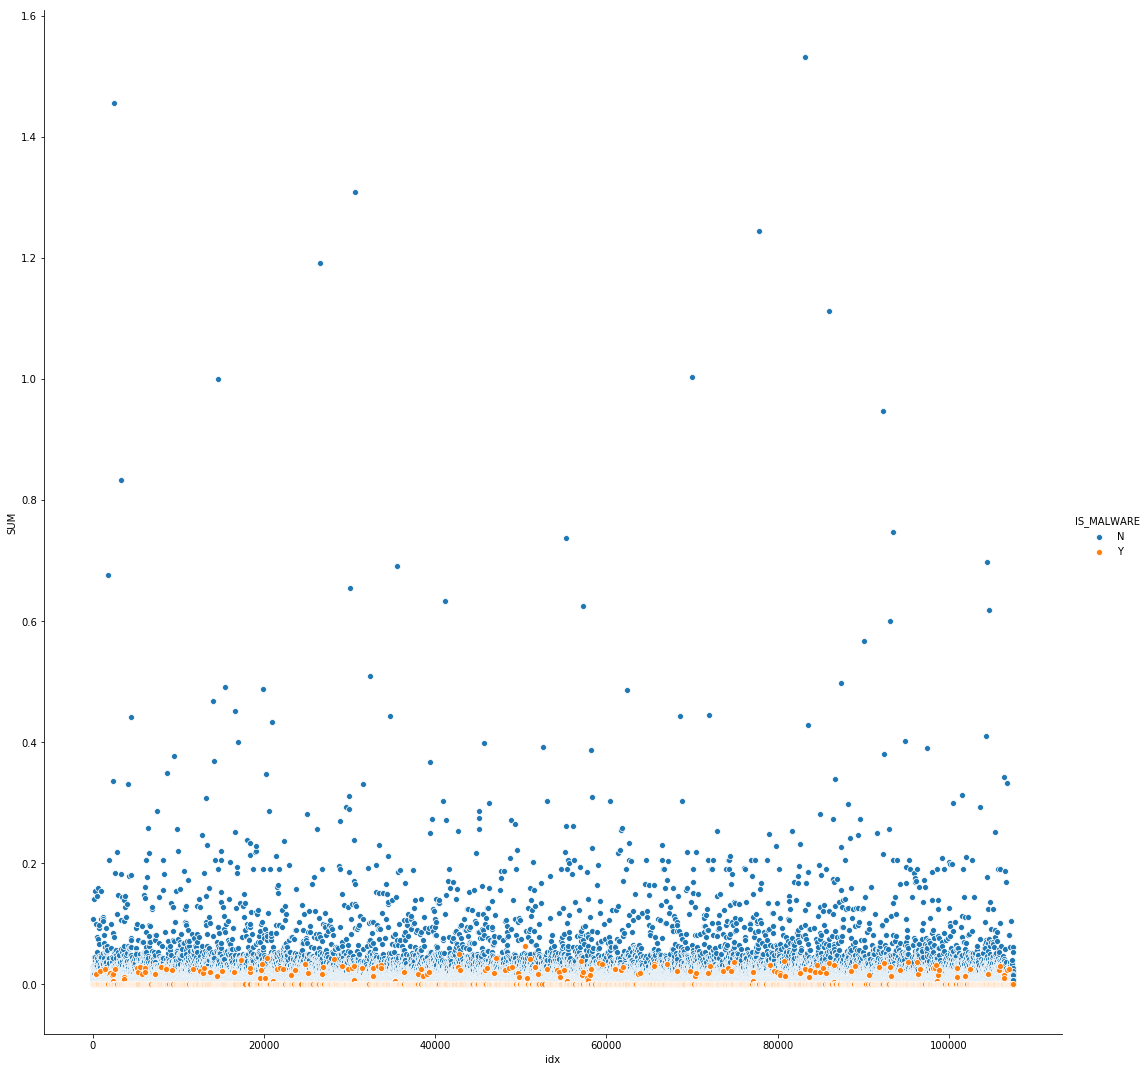

In [167]:
sns.pairplot(x_vars=["idx"], y_vars=["SUM"], data=datas_compare, hue="IS_MALWARE", size=15)

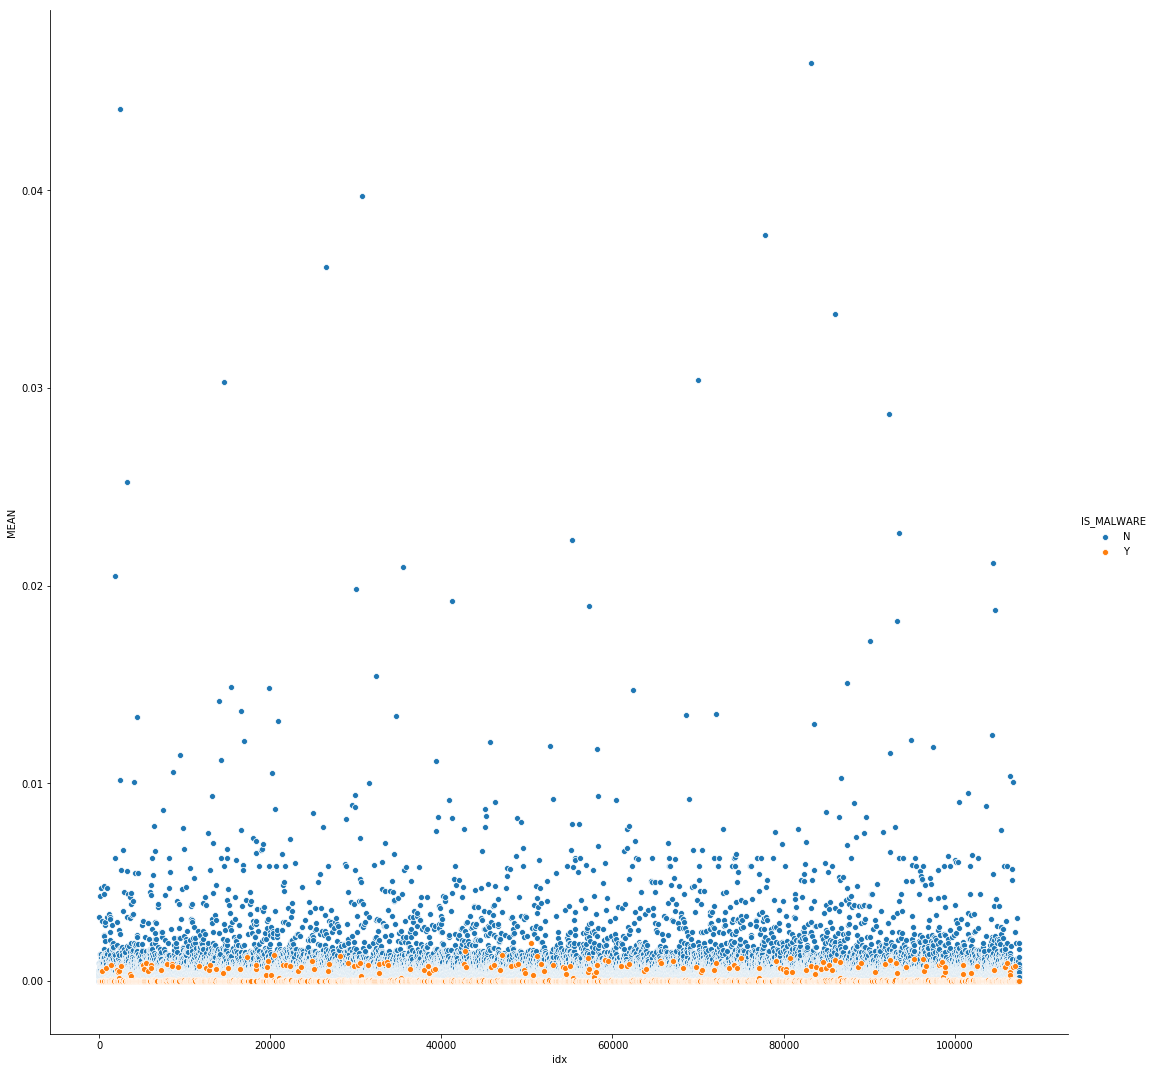

In [168]:
sns.pairplot(x_vars=["idx"], y_vars=["MEAN"], data=datas_compare, hue="IS_MALWARE", size=15)